# CIS 545 Final Project: NBA Sports Betting and Game Predictions
## Kevin Xu and William Harkless

In recent years, basketball has become a sport that has heavily invested in its data tracking for every single play that happens on the court. This opens up the possibility for any observer to uncover different statistical advantages each team or player may have over one another and determine outcomes of games or entire seasons. Of course, basketball data is incredibly noisy and unpredictable with teams being upset very routinely in the regular season. Thus, it would be ideal to examine whether a statistical model could do a better job of predicting the winner of a game beyond the standard "eye test" or a comparison of a handful of stats. We will be exploring box stats throughout the 2014-2020 seasons and trying to predict the outcome of the 2021 season.
<br>
While prediction accuracy is great, we are aware that with the growing number of states that have legalized sports betting, the real interest for many fans is whether or not a model could "beat the bookies". Thus, we will also be taking our best performing model and seeing where it stands against the book odds if we were to use it to place bets.

## Data Wrangling and Cleaning

### Pulling data from NBA website

In [ ]:
import requests
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


One of the most interesting feature-engineered stats is called ELO. This number gives a rough idea of the relative strength of a team compared to its peers. The most popular ELO formula for NBA teams was developed by Nate Silver and fivethirtyeight. The formula works as follows:
Each team starts off with an ELO of 1500. After each game, their ELO, $$R_{i+1}$$
is recalculated, as shown below.

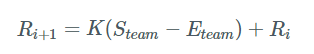

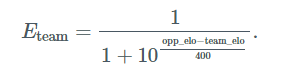
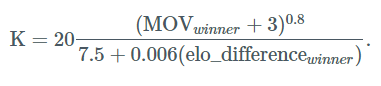

After each season, there is a soft reset of the ELO.

Below, we've calculated the ELO for each team starting from 2008 all the way until 2021. We pulled data from the NBA stats site's API which contains every single game played during a season and the results of each game, allowing us to calculate the ELO changes.

In [ ]:
elos = None
elos_by_year = []
for i in range(8, 21):
    if i < 9:
        season_id = f'200{i}-0{i+1}'
    elif i == 9:
        season_id = f'200{i}-{i+1}'
    else:
        season_id = f'20{i}-{i+1}'
    per_mode = 'Totals'
    
    team_stats_url = f'https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season={season_id}&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision='
    box_scores_url = f'https://stats.nba.com/stats/leaguegamelog?Counter=1000&DateFrom=&DateTo=&Direction=DESC&LeagueID=00&PlayerOrTeam=T&Season={season_id}&SeasonType=Regular+Season&Sorter=DATE'
    adv_stats_url = f'https://stats.nba.com/stats/teamgamelogs?DateFrom=&DateTo=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Advanced&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=Totals&Period=0&PlusMinus=N&Rank=N&Season={season_id}&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&VsConference=&VsDivision='
    headers  = {
        'Connection': 'keep-alive',
        'Accept': 'application/json, text/plain, */*',
        'x-nba-stats-token': 'true',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
        'x-nba-stats-origin': 'stats',
        'Sec-Fetch-Site': 'same-origin',
        'Sec-Fetch-Mode': 'cors',
        'Referer': 'https://stats.nba.com/',
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept-Language': 'en-US,en;q=0.9',
    }
    response = requests.get(url = box_scores_url, headers = headers).json()
    box_score = response['resultSets'][0]['rowSet']
    response_adv = requests.get(url = adv_stats_url, headers = headers).json()
    adv_box_score = response_adv['resultSets'][0]['rowSet']
    columns_list = ["SEASON_YEAR", 
                    "TEAM_ID",
                    "TEAM_ABBREVIATION",
                    "TEAM_NAME",
                    "GAME_ID",
                    "GAME_DATE",
                    "MATCHUP",
                    "WL",
                    "MIN",
                    "FGM",
                    "FGA",
                    "FG_PCT",
                    "FG3M",
                    "FG3A",
                    "FG3_PCT",
                    "FTM",
                    "FTA",
                    "FT_PCT",
                    "OREB",
                    "DREB",
                    "REB",
                    "AST",
                    "STL",
                    "BLK",
                    "TOV",
                    "PF",
                    "PTS",
                    "PLUS_MINUS",
                    "VIDEO_AVAILABLE"]
    df = pd.DataFrame(box_score, columns = columns_list)
    df = df.reindex(index=df.index[::-1]).reset_index(drop = True)

    df_elo = df[['TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'PTS']].merge(df[['TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'MATCHUP','WL', 'PTS']], on = 'GAME_ID', suffixes = ['_t1','_t2'])
    df_elo = df_elo[df_elo['TEAM_ABBREVIATION_t1'] != df_elo['TEAM_ABBREVIATION_t2']][['GAME_ID', 'GAME_DATE_t1','MATCHUP_t1', 'PTS_t1', 'PTS_t2']]
    df_elo = df_elo.rename(columns = {'GAME_DATE_t1': 'GAME_DATE', 'MATCHUP_t1': 'MATCHUP'})
    df_elo = df_elo.iloc[:-2:2]
    df_elo = df_elo.dropna()

    from collections import defaultdict
    
    if elos is None:
        elos = defaultdict(lambda: [1500])
    for index, row in df_elo.iterrows():
        teams = row['MATCHUP'].split()
        t1 = teams[0]
        t2 = teams[2]
        t1_pts = row['PTS_t1']
        t2_pts = row['PTS_t2']
        prev_t1_elo = elos[t1][-1]
        prev_t2_elo = elos[t2][-1]

        if teams[1] == '@':
            t2_elo = prev_t2_elo + 100
            t1_elo = prev_t1_elo

        else:
            t1_elo = prev_t1_elo + 100
            t2_elo = prev_t2_elo

        E_t1 = 1/(1 + 10**((t2_elo - t1_elo)/400))
        E_t2 = 1/(1 + 10**((t1_elo - t2_elo)/400))
        k = 20*((abs(t1_pts - t2_pts) + 3)**0.8)/(7.5 + 0.006*(abs(t1_elo - t2_elo)))

        if t1_pts > t2_pts:
            elos[t1].append(k*(1 - E_t1) + prev_t1_elo)
            elos[t2].append(k*(0 - E_t2) + prev_t2_elo)
        else:
            elos[t2].append(k*(1 - E_t1) + prev_t2_elo)
            elos[t1].append(k*(0 - E_t2) + prev_t1_elo)
    prev_elos = defaultdict(lambda: [1500])
    print(f'20{i} year done')
    for team, elos in elos.items():
        prev_elos[team] = [0.65*elos[-1] + 0.35*1505]
    elos = prev_elos
    elos_by_year.append(prev_elos)

208 year done
209 year done
2010 year done
2011 year done
2012 year done
2013 year done
2014 year done
2015 year done
2016 year done
2017 year done
2018 year done
2019 year done
2020 year done


In [ ]:
for d in elos_by_year:
    for team, elos in d.items():
        d[team] = [elos[-1]]

Next, we pulled all the basic and advanced team stats for every game played in an individual season. This was done for every season between the 2014 and 2021 season, inclusive.

In [ ]:
season_id = '2014-15' #Change season id based on which seasons you want to scrape data from
per_mode = 'Totals'

team_stats_url = f'https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season={season_id}&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision='
box_scores_url = f'https://stats.nba.com/stats/leaguegamelog?Counter=1000&DateFrom=&DateTo=&Direction=DESC&LeagueID=00&PlayerOrTeam=T&Season={season_id}&SeasonType=Regular+Season&Sorter=DATE'
adv_stats_url = f'https://stats.nba.com/stats/teamgamelogs?DateFrom=&DateTo=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Advanced&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=Totals&Period=0&PlusMinus=N&Rank=N&Season={season_id}&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&VsConference=&VsDivision='

In [ ]:
headers  = {
    'Connection': 'keep-alive',
    'Accept': 'application/json, text/plain, */*',
    'x-nba-stats-token': 'true',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
    'x-nba-stats-origin': 'stats',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-Mode': 'cors',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9',
}

response = requests.get(url = box_scores_url, headers = headers).json()
box_score = response['resultSets'][0]['rowSet']
response_adv = requests.get(url = adv_stats_url, headers = headers).json()
adv_box_score = response_adv['resultSets'][0]['rowSet']

columns_list = ["SEASON_YEAR", 
                "TEAM_ID",
                "TEAM_ABBREVIATION",
                "TEAM_NAME",
                "GAME_ID",
                "GAME_DATE",
                "MATCHUP",
                "WL",
                "MIN",
                "FGM",
                "FGA",
                "FG_PCT",
                "FG3M",
                "FG3A",
                "FG3_PCT",
                "FTM",
                "FTA",
                "FT_PCT",
                "OREB",
                "DREB",
                "REB",
                "AST",
                "STL",
                "BLK",
                "TOV",
                "PF",
                "PTS",
                "PLUS_MINUS",
                "VIDEO_AVAILABLE"]

In [ ]:
df = pd.DataFrame(box_score, columns = columns_list)
df = df.reindex(index=df.index[::-1]).reset_index(drop = True)
df.head()

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22014,1610612759,SAS,San Antonio Spurs,0021400002,2014-10-28,SAS vs. DAL,W,240,37,...,29,38,23,5,3,21,20,101,1,1
1,22014,1610612742,DAL,Dallas Mavericks,0021400002,2014-10-28,DAL @ SAS,L,240,38,...,24,33,17,9,3,10,20,100,-1,1
2,22014,1610612745,HOU,Houston Rockets,0021400003,2014-10-28,HOU @ LAL,W,240,31,...,33,47,22,7,3,14,30,108,18,1
3,22014,1610612747,LAL,Los Angeles Lakers,0021400003,2014-10-28,LAL vs. HOU,L,240,28,...,25,36,16,7,3,13,32,90,-18,1
4,22014,1610612753,ORL,Orlando Magic,0021400001,2014-10-28,ORL @ NOP,L,240,32,...,40,56,17,5,9,18,25,84,-17,1


In [ ]:
df_elo = df[['TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'PTS']].merge(df[['TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'MATCHUP','WL', 'PTS']], on = 'GAME_ID', suffixes = ['_t1','_t2'])
df_elo = df_elo[df_elo['TEAM_ABBREVIATION_t1'] != df_elo['TEAM_ABBREVIATION_t2']][['GAME_ID', 'GAME_DATE_t1','MATCHUP_t1', 'PTS_t1', 'PTS_t2']]
df_elo = df_elo.rename(columns = {'GAME_DATE_t1': 'GAME_DATE', 'MATCHUP_t1': 'MATCHUP'})
df_elo = df_elo.iloc[:-2:2]
df_elo = df_elo.dropna()
df_elo.head()

,GAME_ID,GAME_DATE,MATCHUP,PTS_t1,PTS_t2
1,0021400002,2014-10-28,SAS vs. DAL,101,100
5,0021400003,2014-10-28,HOU @ LAL,108,90
9,0021400001,2014-10-28,ORL @ NOP,84,101
13,0021400010,2014-10-29,NYK vs. CHI,80,104
17,0021400013,2014-10-29,PHX vs. LAL,119,99


We load in the starting ELO for the season based on our previously calculated values

In [ ]:
from collections import defaultdict
h_elo = []
v_elo = []
idx = int(season_id[:4]) - 2022
elos = elos_by_year[idx]
print(elos)
for index, row in df_elo.iterrows():
    teams = row['MATCHUP'].split()
    t1 = teams[0]
    t2 = teams[2]
    t1_pts = row['PTS_t1']
    t2_pts = row['PTS_t2']
    prev_t1_elo = elos[t1][-1]
    prev_t2_elo = elos[t2][-1]

    if teams[1] == '@':
        t2_elo = prev_t2_elo + 100
        t1_elo = prev_t1_elo
        h_elo.append(prev_t2_elo)
        v_elo.append(prev_t1_elo)
    else:
        t1_elo = prev_t1_elo + 100
        t2_elo = prev_t2_elo
        h_elo.append(prev_t1_elo)
        v_elo.append(prev_t2_elo)
    E_t1 = 1/(1 + 10**((t2_elo - t1_elo)/400))
    E_t2 = 1/(1 + 10**((t1_elo - t2_elo)/400))
    k = 20*((abs(t1_pts - t2_pts) + 3)**0.8)/(7.5 + 0.006*(abs(t1_elo - t2_elo)))

    if t1_pts > t2_pts:
        elos[t1].append(k*(1 - E_t1) + prev_t1_elo)
        elos[t2].append(k*(0 - E_t2) + prev_t2_elo)
    else:
        elos[t2].append(k*(1 - E_t1) + prev_t2_elo)
        elos[t1].append(k*(0 - E_t2) + prev_t1_elo)

defaultdict(<function <lambda> at 0x7fa75f9104d0>, {'BOS': [1466.4772807221395], 'CLE': [1539.3368783064602], 'MIL': [1206.381826630189], 'CHI': [1858.5268668899428], 'LAL': [1172.6594955795858], 'POR': [1846.5821941754086], 'SAS': [2271.748041071516], 'PHX': [1441.2044680221459], 'ATL': [1786.5855754951772], 'ORL': [968.0216668828256], 'PHI': [675.9211963072], 'TOR': [1561.4959092294712], 'MIN': [974.0034940073803], 'SAC': [890.0120347619022], 'MIA': [1728.1176549477307], 'NYK': [1096.5728756322694], 'NOH': [1369.4294912934643], 'GSW': [2167.2653356539445], 'WAS': [1409.5446337547314], 'NJN': [1336.5497181010592], 'HOU': [1965.1001271233654], 'MEM': [1874.3676895532008], 'LAC': [2195.269668556901], 'OKC': [2124.2475896017113], 'DET': [1034.9760940957258], 'IND': [1660.2966558422622], 'DEN': [1544.20487093121], 'UTA': [1296.0661354324254], 'CHA': [1051.3247958462512], 'DAL': [1781.7455184132034], 'BKN': [1330.2365539115312], 'NOP': [1519.0523296339234]})


In [ ]:
df_elo['H_ELO'] = h_elo
df_elo['V_ELO'] = v_elo
df_elo.head()

,GAME_ID,GAME_DATE,MATCHUP,PTS_t1,PTS_t2,H_ELO,V_ELO
1,0021400002,2014-10-28,SAS vs. DAL,101,100,2271.748041,1781.745518
5,0021400003,2014-10-28,HOU @ LAL,108,90,1172.659496,1965.100127
9,0021400001,2014-10-28,ORL @ NOP,84,101,1519.052330,968.021667
13,0021400010,2014-10-29,NYK vs. CHI,80,104,1096.572876,1858.526867
17,0021400013,2014-10-29,PHX vs. LAL,119,99,1441.204468,1172.302048


In [ ]:
home_win = []
win = True
team_ids = {}
for index, row in df.iterrows():
    teams = row['MATCHUP'].split()
    t1 = teams[0]
    t2 = teams[2]
    win = row['WL'] == 'W'
    if teams[1] == '@':
        
        if win:
            home_win.append(0)
        else:
            home_win.append(1)
    else:
        if win:
            home_win.append(1)
        else:
            home_win.append(0)
    team_ids[t1] = row['TEAM_ID']
df['HOME_WIN'] = home_win

In [ ]:
adv_columns_list = ["SEASON_YEAR",
                    "TEAM_ID",
                    "TEAM_ABBREVIATION",
                    "TEAM_NAME",
                    "GAME_ID",
                    "GAME_DATE",
                    "MATCHUP",
                    "WL",
                    "MIN",
                    "E_OFF_RATING",
                    "OFF_RATING",
                    "E_DEF_RATING",
                    "DEF_RATING",
                    "E_NET_RATING",
                    "NET_RATING",
                    "AST_PCT",
                    "AST_TO",
                    "AST_RATIO",
                    "OREB_PCT",
                    "DREB_PCT",
                    "REB_PCT",
                    "TM_TOV_PCT",
                    "EFG_PCT",
                    "TS_PCT",
                    "E_PACE",
                    "PACE",
                    "PACE_PER40",
                    "POSS",
                    "PIE",
                    "GP_RANK",
                    "W_RANK",
                    "L_RANK",
                    "W_PCT_RANK",
                    "MIN_RANK",
                    "OFF_RATING_RANK",
                    "DEF_RATING_RANK",
                    "NET_RATING_RANK",
                    "AST_PCT_RANK",
                    "AST_TO_RANK",
                    "AST_RATIO_RANK",
                    "OREB_PCT_RANK",
                    "DREB_PCT_RANK",
                    "REB_PCT_RANK",
                    "TM_TOV_PCT_RANK",
                    "EFG_PCT_RANK",
                    "TS_PCT_RANK",
                    "PACE_RANK",
                    "PIE_RANK"]

In [ ]:
df_adv = pd.DataFrame(adv_box_score, columns = adv_columns_list)
df_adv.head()

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,E_OFF_RATING,...,AST_TO_RANK,AST_RATIO_RANK,OREB_PCT_RANK,DREB_PCT_RANK,REB_PCT_RANK,TM_TOV_PCT_RANK,EFG_PCT_RANK,TS_PCT_RANK,PACE_RANK,PIE_RANK
0,2014-15,1610612749,MIL,Milwaukee Bucks,0021401221,2015-04-15T00:00:00,MIL vs. BOS,L,48.0,103.1,...,582,53,401,595,341,1769,1133,1451,637,1401
1,2014-15,1610612739,CLE,Cleveland Cavaliers,0021401225,2015-04-15T00:00:00,CLE vs. WAS,W,53.0,109.2,...,837,357,1669,1913,1847,1399,390,643,1387,1189
2,2014-15,1610612762,UTA,Utah Jazz,0021401219,2015-04-15T00:00:00,UTA @ HOU,L,48.0,82.8,...,1260,1547,1096,648,1779,1138,2302,2404,41,2385
3,2014-15,1610612766,CHA,Charlotte Hornets,0021401228,2015-04-15T00:00:00,CHA @ TOR,L,48.0,103.5,...,2055,2003,1490,279,736,1702,1049,871,2449,1581
4,2014-15,1610612759,SAS,San Antonio Spurs,0021401223,2015-04-15T00:00:00,SAS @ NOP,L,48.0,107.6,...,432,22,2334,523,1168,1486,187,260,1269,1237


In [ ]:
keep_columns_list = ["GAME_ID",
                    "MATCHUP",
                    "E_OFF_RATING",
                    "OFF_RATING",
                    "E_DEF_RATING",
                    "DEF_RATING",
                    "E_NET_RATING",
                    "NET_RATING",
                    "AST_PCT",
                    "AST_TO",
                    "AST_RATIO",
                    "OREB_PCT",
                    "DREB_PCT",
                    "REB_PCT",
                    "TM_TOV_PCT",
                    "EFG_PCT",
                    "TS_PCT",
                    "E_PACE",
                    "PACE",
                    "PACE_PER40",
                    "POSS",
                    "PIE"]

In [ ]:
df_adv = df_adv[keep_columns_list]
df_adv = pd.merge(left=df, right=df_adv, left_on=['GAME_ID', 'MATCHUP'], right_on=['GAME_ID', 'MATCHUP'])
df_adv = df_adv.iloc[::-1].reset_index(drop = True)

df_adv.head()

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE
0,22014,1610612740,NOP,New Orleans Pelicans,0021401223,2015-04-15,NOP vs. SAS,W,240,43,...,0.829,0.500,0.096,0.548,0.574,95.9,94.0,78.33,94,0.501
1,22014,1610612759,SAS,San Antonio Spurs,0021401223,2015-04-15,SAS @ NOP,L,240,45,...,0.767,0.500,0.160,0.589,0.608,95.9,94.0,78.33,94,0.499
2,22014,1610612754,IND,Indiana Pacers,0021401220,2015-04-15,IND @ MEM,L,240,32,...,0.571,0.438,0.155,0.462,0.491,84.5,84.5,70.42,84,0.372
3,22014,1610612763,MEM,Memphis Grizzlies,0021401220,2015-04-15,MEM vs. IND,W,240,36,...,0.681,0.562,0.153,0.487,0.543,84.5,84.5,70.42,85,0.628
4,22014,1610612761,TOR,Toronto Raptors,0021401228,2015-04-15,TOR vs. CHA,W,240,38,...,0.732,0.475,0.131,0.571,0.584,84.4,83.5,69.58,84,0.543


We want to get an idea of how well a team has been playing recently, so we decided to average their stats across their past 5 games. These will be used as key features in our model later on.

In [ ]:
from datetime import datetime

n_games = len(df_adv)
home_df = pd.DataFrame()
visitor_df = pd.DataFrame()


for index, row in df_adv.iterrows():
    i = index
    games = []
    wins = 0
    while len(games) < 5 and i < n_games - 1:
        i += 1
        if df_adv.iloc[i]['TEAM_ABBREVIATION'] == row['TEAM_ABBREVIATION']:
            games.append(df_adv.iloc[i].to_frame().transpose())
            if df_adv.iloc[i]['WL'] == 'W':
                wins += 1
    if len(games) == 0:
        continue
    else:
        past_5_games = pd.concat(games)
    last_game = games[0]
    datetime_curr = datetime.strptime(row['GAME_DATE'], '%Y-%m-%d')
    datetime_last = datetime.strptime(last_game.iloc[0]['GAME_DATE'], '%Y-%m-%d')
    diff = datetime_curr - datetime_last
    past_5_games = past_5_games[['FGM', "FGA","FG_PCT","FG3M","FG3A","FG3_PCT","FTM","FTA","FT_PCT","OREB","DREB","REB","AST","STL","BLK","TOV","PF","PTS","PLUS_MINUS","OFF_RATING", "DEF_RATING", "NET_RATING","AST_PCT","AST_TO","AST_RATIO","OREB_PCT","DREB_PCT","REB_PCT","TM_TOV_PCT","EFG_PCT","TS_PCT","E_PACE","PACE","PACE_PER40","POSS","PIE"]]
    past_5_games.astype('int64').dtypes
    past_5_games = past_5_games.mean(axis = 0).to_frame().transpose()
    past_5_games['WINS'] = wins

    if row['MATCHUP'].split()[1] == '@':
        new_columns = ['V_AVG_' + column for column in past_5_games.columns]
        past_5_games.set_axis(new_columns, axis=1, inplace=True)
        past_5_games.reset_index(drop=True, inplace=True)

        if diff.days == 1:
            past_5_games['V_CONSEC'] = 1
        else:
            past_5_games['V_CONSEC'] = 0

        if len(visitor_df) == 0:
            visitor_df = past_5_games
        else:
            visitor_df = visitor_df.append(past_5_games)
    else:
        new_columns = ['H_AVG_' + column for column in past_5_games.columns]
        past_5_games.set_axis(new_columns, axis=1, inplace=True)
        past_5_games.reset_index(drop=True, inplace=True)
        
        if diff.days == 1:
            past_5_games['H_CONSEC'] = 1
        else:
            past_5_games['H_CONSEC'] = 0
        
        if len(home_df) == 0:
            home_df = past_5_games
        else:
            home_df = home_df.append(past_5_games)
visitor_df.reset_index(drop = True, inplace = True)
home_df.reset_index(drop = True, inplace = True)

In [ ]:
home_df.tail()

,H_AVG_FGM,H_AVG_FGA,H_AVG_FG_PCT,H_AVG_FG3M,H_AVG_FG3A,H_AVG_FG3_PCT,H_AVG_FTM,H_AVG_FTA,H_AVG_FT_PCT,H_AVG_OREB,...,H_AVG_TM_TOV_PCT,H_AVG_EFG_PCT,H_AVG_TS_PCT,H_AVG_E_PACE,H_AVG_PACE,H_AVG_PACE_PER40,H_AVG_POSS,H_AVG_PIE,H_AVG_WINS,H_CONSEC
1208,36.0,71.0,0.507,7.0,24.0,0.292,25.0,30.0,0.8330,10.0,...,0.169,0.556,0.618,89.80,89.0,74.170,89.0,0.671,1,0
1209,32.5,82.5,0.392,3.5,11.5,0.304,26.0,32.0,0.8175,11.5,...,0.150,0.413,0.489,97.05,93.5,77.915,93.5,0.386,0,0
1210,39.0,86.0,0.453,6.0,12.0,0.500,17.0,23.0,0.7390,19.0,...,0.237,0.488,0.525,99.00,96.5,80.420,97.0,0.458,0,1
1211,38.0,78.0,0.487,8.0,21.0,0.381,16.0,19.0,0.8420,9.0,...,0.116,0.538,0.579,88.20,86.0,71.670,86.0,0.488,0,0
1212,32.0,84.0,0.381,4.0,11.0,0.364,16.0,21.0,0.7620,16.0,...,0.189,0.405,0.450,96.40,95.0,79.170,95.0,0.403,0,0


In [ ]:
df_matchups = df.iloc[::2]
df_matchups = df_matchups.reset_index(drop = True)
df_matchups = pd.merge(left = df_matchups, right = df_elo[['GAME_ID', 'H_ELO', 'V_ELO']], on = ['GAME_ID'])
df_matchups.head()

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,HOME_WIN,H_ELO,V_ELO
0,22014,1610612759,SAS,San Antonio Spurs,0021400002,2014-10-28,SAS vs. DAL,W,240,37,...,5,3,21,20,101,1,1,1,2271.748041,1781.745518
1,22014,1610612745,HOU,Houston Rockets,0021400003,2014-10-28,HOU @ LAL,W,240,31,...,7,3,14,30,108,18,1,0,1172.659496,1965.100127
2,22014,1610612753,ORL,Orlando Magic,0021400001,2014-10-28,ORL @ NOP,L,240,32,...,5,9,18,25,84,-17,1,1,1519.052330,968.021667
3,22014,1610612752,NYK,New York Knicks,0021400010,2014-10-29,NYK vs. CHI,L,240,31,...,9,5,12,22,80,-24,1,0,1096.572876,1858.526867
4,22014,1610612756,PHX,Phoenix Suns,0021400013,2014-10-29,PHX vs. LAL,W,240,45,...,5,3,14,25,119,20,1,1,1441.204468,1172.302048


In [ ]:
clean_df = df_matchups[['GAME_DATE','MATCHUP', 'HOME_WIN', 'H_ELO', 'V_ELO', 'TEAM_ID']].iloc[::-1].reset_index(drop = True)
clean_df.head()

,GAME_DATE,MATCHUP,HOME_WIN,H_ELO,V_ELO,TEAM_ID
0,2015-04-15,MEM vs. IND,1,1993.283159,1600.854448,1610612763
1,2015-04-15,CHA @ TOR,1,1649.526556,931.619824,1610612766
2,2015-04-15,OKC @ MIN,0,671.726190,2247.032973,1610612760
3,2015-04-15,DAL vs. POR,1,1816.647622,2097.939526,1610612742
4,2015-04-15,MIL vs. BOS,0,1202.327278,1436.739900,1610612749


In [ ]:
full_stats_df = pd.concat([clean_df, home_df, visitor_df], axis=1)
full_stats_df['ELO_DIFF'] = full_stats_df["H_ELO"] - full_stats_df["V_ELO"]

In [ ]:
full_stats_df.head()

,GAME_DATE,MATCHUP,HOME_WIN,H_ELO,V_ELO,TEAM_ID,H_AVG_FGM,H_AVG_FGA,H_AVG_FG_PCT,H_AVG_FG3M,...,V_AVG_EFG_PCT,V_AVG_TS_PCT,V_AVG_E_PACE,V_AVG_PACE,V_AVG_PACE_PER40,V_AVG_POSS,V_AVG_PIE,V_AVG_WINS,V_CONSEC,ELO_DIFF
0,2015-04-15,MEM vs. IND,1,1993.283159,1600.854448,1610612763,36.4,84.4,0.4296,7.4,...,0.5538,0.5860,97.18,96.200,80.166,96.4,0.5994,5.0,0.0,392.428711
1,2015-04-15,CHA @ TOR,1,1649.526556,931.619824,1610612766,38.0,84.0,0.4530,4.2,...,0.5214,0.5572,95.14,93.028,77.526,97.0,0.6086,5.0,1.0,717.906732
2,2015-04-15,OKC @ MIN,0,671.726190,2247.032973,1610612760,36.4,83.4,0.4372,9.0,...,0.4256,0.4574,93.66,91.900,76.582,92.0,0.3722,0.0,0.0,-1575.306783
3,2015-04-15,DAL vs. POR,1,1816.647622,2097.939526,1610612742,35.0,81.8,0.4264,5.4,...,0.4734,0.4980,99.08,97.900,81.584,97.6,0.4494,2.0,0.0,-281.291904
4,2015-04-15,MIL vs. BOS,0,1202.327278,1436.739900,1610612749,43.0,89.6,0.4768,7.4,...,0.5186,0.5430,98.02,95.500,79.582,95.8,0.4862,1.0,0.0,-234.412621


Now we can just save this season's data to a csv on our google drive

In [ ]:
full_stats_df.to_csv(f'/content/drive/MyDrive/NBA_Data/{season_id[:4]}.csv')

### Combining stats with betting odds

We were able to find historical betting odds for the NBA dating back to the 2007 at https://www.sportsbookreviewsonline.com/scoresoddsarchives/nba/nbaoddsarchives.htm.
<br>
We can combine this with our statistics to form a full dataframe that we can process later when building and testing models.

In [ ]:
year = 2014

stats_df = pd.read_csv(f'/content/drive/MyDrive/NBA_Data/{year}.csv')

In [ ]:
stats_df.dropna(inplace = True)
stats_df

,Unnamed: 0,GAME_DATE,MATCHUP,HOME_WIN,H_ELO,V_ELO,TEAM_ID,H_AVG_FGM,H_AVG_FGA,H_AVG_FG_PCT,...,V_AVG_EFG_PCT,V_AVG_TS_PCT,V_AVG_E_PACE,V_AVG_PACE,V_AVG_PACE_PER40,V_AVG_POSS,V_AVG_PIE,V_AVG_WINS,V_CONSEC,ELO_DIFF
0,0,2015-04-15,MEM vs. IND,1,1987.175063,1608.743691,1610612763,36.4,84.4,0.4296,...,0.5538,0.5860,97.18,96.200,80.166,96.4,0.5994,5.0,0.0,378.431372
1,1,2015-04-15,CHA @ TOR,1,1660.098802,884.438398,1610612766,38.0,84.0,0.4530,...,0.5214,0.5572,95.14,93.028,77.526,97.0,0.6086,5.0,1.0,775.660404
2,2,2015-04-15,OKC @ MIN,0,686.010853,2246.400421,1610612760,36.4,83.4,0.4372,...,0.4256,0.4574,93.66,91.900,76.582,92.0,0.3722,0.0,0.0,-1560.389568
3,3,2015-04-15,DAL vs. POR,1,1806.848621,2108.657416,1610612742,35.0,81.8,0.4264,...,0.4734,0.4980,99.08,97.900,81.584,97.6,0.4494,2.0,0.0,-301.808795
4,4,2015-04-15,MIL vs. BOS,0,1182.272614,1430.196739,1610612749,43.0,89.6,0.4768,...,0.5186,0.5430,98.02,95.500,79.582,95.8,0.4862,1.0,0.0,-247.924125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,1208,2014-10-31,LAL vs. LAC,0,1162.130766,2221.518412,1610612747,36.0,71.0,0.5070,...,0.5210,0.5710,86.40,86.500,72.080,86.0,0.4500,0.0,1.0,-1059.387646
1209,1209,2014-10-30,DET @ MIN,1,986.811930,1047.830854,1610612765,32.5,82.5,0.3920,...,0.4310,0.4740,97.50,96.000,80.000,95.0,0.4300,1.0,1.0,-61.018924
1210,1210,2014-10-30,UTA @ DAL,1,1771.178754,1246.730249,1610612762,39.0,86.0,0.4530,...,0.4050,0.4280,100.00,95.500,79.580,96.0,0.3850,0.0,1.0,524.448505
1211,1211,2014-10-30,NYK @ CLE,0,1542.081331,1101.772242,1610612752,38.0,78.0,0.4870,...,0.4880,0.5260,91.30,89.500,74.580,89.0,0.4690,0.0,1.0,440.309089


In [ ]:
odds_df = pd.read_excel(f'/content/drive/MyDrive/NBA_Data/{year}_odds.xlsx')
odds_df = odds_df[odds_df['VH'] != 'N']
odds_df = odds_df[['Date', 'VH', 'Team', 'Final', 'ML']]
odds_df.tail()

,Date,VH,Team,Final,ML
2617,611,H,Cleveland,82,161
2618,614,V,Cleveland,91,370
2619,614,H,GoldenState,104,-465
2620,616,V,GoldenState,105,-150
2621,616,H,Cleveland,97,130


We need to format the date so that we can join our two dataframes

In [ ]:
def date_transform(date):
    if len(str(date)) < 4:
        date = '0' + date
    if int(str(date)[0:2]) > 6:
        return f'{year}-{str(date)[0:2]}-{str(date)[2:4]}'
    else:
        return f'{str(int(year)+1)}-{str(date)[0:2]}-{str(date)[2:4]}'
odds_df['Date'] = odds_df['Date'].apply(lambda x: '0' + str(x) if len(str(x)) < 4 else str(x))
odds_df['Date'] = odds_df['Date'].apply(lambda x: f'{year}-{str(x)[0:2]}-{str(x)[2:4]}' if int(str(x)[0:2]) > 6 else f'{str(int(year) + 1)}-{str(x)[0:2]}-{str(x)[2:4]}')

In [ ]:
odds_df['Team'] = odds_df['Team'].apply(lambda x: x.replace(" ", ""))
odds_df['VH'] = odds_df['VH'].apply(lambda x: 'H' if x == 'N' else x)
odds_df.tail()

,Date,VH,Team,Final,ML
2617,2015-06-11,H,Cleveland,82,161
2618,2015-06-14,V,Cleveland,91,370
2619,2015-06-14,H,GoldenState,104,-465
2620,2015-06-16,V,GoldenState,105,-150
2621,2015-06-16,H,Cleveland,97,130


In [ ]:
city_team_abbrevs = {'NOP': 'NewOrleans', 'MIL': 'Milwaukee', 'SAS': 'SanAntonio', 'DET': 'Detroit', 'CHI': 'Chicago', 'WAS': 'Washington', 'LAC': 'LAClippers', 'BKN': 'Brooklyn', 'DEN': 'Denver', 'HOU': 'Houston', 'GSW': 'GoldenState', 'UTA': 'Utah', 'LAL': 'LALakers', 'PHI': 'Philadelphia', 'NYK': 'NewYork', 'BOS': 'Boston', 'PHX': 'Phoenix', 'DAL': 'Dallas', 'POR': 'Portland', 'CLE': 'Cleveland', 'MIA': 'Miami', 'OKC': 'OklahomaCity', 'ATL': 'Atlanta', 'MIN': 'Minnesota', 'TOR': 'Toronto', 'SAC': 'Sacramento', 'IND': 'Indiana', 'MEM': 'Memphis', 'CHA': 'Charlotte', 'ORL': 'Orlando'}
reverse_cities_d = {y:x for x,y in city_team_abbrevs.items()}
matchups = []
home = []
visitor = []
home_ml = []
visitor_ml = []
home_score = []
visitor_score = []
date = []
prev_team = None
for index, row in odds_df.iterrows():
    if row['VH'] == 'V':
        if prev_team == 'V':
          print('ERROR PREV WAS V')
          print(row)
        prev_team = 'V'
        visitor.append(reverse_cities_d[row['Team']])
        visitor_ml.append(row['ML'])
        visitor_score.append(row['Final'])
        date.append(row['Date'])
        visitor.append(reverse_cities_d[row['Team']])
        visitor_ml.append(row['ML'])
        visitor_score.append(row['Final'])
        date.append(row['Date'])
    else:
        if prev_team == 'H':
          print('ERROR PREV WAS H')
          print(row)
        prev_team = 'H'
        home.append(reverse_cities_d[row['Team']])
        home_ml.append(row['ML'])
        home_score.append(row['Final'])
        home.append(reverse_cities_d[row['Team']])
        home_ml.append(row['ML'])
        home_score.append(row['Final'])
for i in range(0, len(home), 2):
    matchups.append(f'{visitor[i]} @ {home[i]}')
    matchups.append(f'{home[i]} vs. {visitor[i]}')

In [ ]:
new_odds_d = {'GAME_DATE': date, 'MATCHUP': matchups, 'H_SCORE': home_score, 'V_SCORE': visitor_score, 'H_ML': home_ml, 'V_ML': visitor_ml}
new_odds_df = pd.DataFrame.from_dict(new_odds_d)
new_odds_df.head()

,GAME_DATE,MATCHUP,H_SCORE,V_SCORE,H_ML,V_ML
0,2014-10-28,DAL @ SAS,101,100,-165,140
1,2014-10-28,SAS vs. DAL,101,100,-165,140
2,2014-10-28,ORL @ NOP,101,84,-475,380
3,2014-10-28,NOP vs. ORL,101,84,-475,380
4,2014-10-28,HOU @ LAL,90,108,250,-300


In [ ]:
full_input = pd.merge(left=stats_df, right=new_odds_df, left_on=['GAME_DATE', 'MATCHUP'], right_on=['GAME_DATE', 'MATCHUP'])
full_input = full_input.dropna().iloc[: , 1:]
full_input.head()

,GAME_DATE,MATCHUP,HOME_WIN,H_ELO,V_ELO,TEAM_ID,H_AVG_FGM,H_AVG_FGA,H_AVG_FG_PCT,H_AVG_FG3M,...,V_AVG_PACE_PER40,V_AVG_POSS,V_AVG_PIE,V_AVG_WINS,V_CONSEC,ELO_DIFF,H_SCORE,V_SCORE,H_ML,V_ML
0,2015-04-15,MEM vs. IND,1,1987.175063,1608.743691,1610612763,36.4,84.4,0.4296,7.4,...,80.166,96.4,0.5994,5.0,0.0,378.431372,95,83,110,-130
1,2015-04-15,CHA @ TOR,1,1660.098802,884.438398,1610612766,38.0,84.0,0.4530,4.2,...,77.526,97.0,0.6086,5.0,1.0,775.660404,92,87,-615,465
2,2015-04-15,OKC @ MIN,0,686.010853,2246.400421,1610612760,36.4,83.4,0.4372,9.0,...,76.582,92.0,0.3722,0.0,0.0,-1560.389568,113,138,940,-1340
3,2015-04-15,DAL vs. POR,1,1806.848621,2108.657416,1610612742,35.0,81.8,0.4264,5.4,...,81.584,97.6,0.4494,2.0,0.0,-301.808795,114,98,-245,205
4,2015-04-15,MIL vs. BOS,0,1182.272614,1430.196739,1610612749,43.0,89.6,0.4768,7.4,...,79.582,95.8,0.4862,1.0,0.0,-247.924125,100,105,-230,195


In [ ]:
full_input.to_csv(f'/content/drive/MyDrive/NBA_Data/{year}_fulldata.csv')

## EDA

In [93]:
!pip install pandasql
import pandasql as ps

  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=40c827dd8c5d8ad007b3d66cdafba4eca4aab2690cbd63faa720f50af98e6247
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


### Loading in Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [74]:
import pandas as pd

train_dfs = []

for year in range(2014, 2021):
    temp = pd.read_csv(f'/content/drive/MyDrive/NBA_Data/{year}_fulldata.csv')
    temp["SEASON"] = year
    train_dfs.append(temp)
  
test_df = pd.read_csv(f'/content/drive/MyDrive/NBA_Data/2021_fulldata.csv')
test_df["SEASON"] = 2021

temp_21 = test_df    
test_df.reset_index(drop = True, inplace = True)
test_df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

We need to combine each of the seasons prior to the 2021 NBA season into a single dataframe to use as our training data

In [75]:
full_train_df = pd.concat(train_dfs).iloc[:,1:]
full_dfs = train_dfs
full_dfs.append(temp_21)
full_train_df.reset_index(drop = True, inplace = True)
full_train_df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

In [76]:
full_train_df

,GAME_DATE,MATCHUP,HOME_WIN,H_ELO,V_ELO,TEAM_ID,H_AVG_FGM,H_AVG_FGA,H_AVG_FG_PCT,H_AVG_FG3M,...,V_AVG_POSS,V_AVG_PIE,V_AVG_WINS,V_CONSEC,ELO_DIFF,H_SCORE,V_SCORE,H_ML,V_ML,SEASON
0,2015-04-15,MEM vs. IND,1,1987.175063,1608.743691,1610612763,36.4,84.4,0.4296,7.4,...,96.4,0.5994,5.0,0.0,378.431372,95,83,110,-130,2014
1,2015-04-15,CHA @ TOR,1,1660.098802,884.438398,1610612766,38.0,84.0,0.4530,4.2,...,97.0,0.6086,5.0,1.0,775.660404,92,87,-615,465,2014
2,2015-04-15,OKC @ MIN,0,686.010853,2246.400421,1610612760,36.4,83.4,0.4372,9.0,...,92.0,0.3722,0.0,0.0,-1560.389568,113,138,940,-1340,2014
3,2015-04-15,DAL vs. POR,1,1806.848621,2108.657416,1610612742,35.0,81.8,0.4264,5.4,...,97.6,0.4494,2.0,0.0,-301.808795,114,98,-245,205,2014
4,2015-04-15,MIL vs. BOS,0,1182.272614,1430.196739,1610612749,43.0,89.6,0.4768,7.4,...,95.8,0.4862,1.0,0.0,-247.924125,100,105,-230,195,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8082,2020-12-26,TOR @ SAS,1,1664.998259,1944.984303,1610612761,36.0,87.0,0.4140,8.0,...,104.0,0.4910,1.0,0.0,-279.986045,119,114,125,-145,2020
8083,2020-12-25,LAC @ DEN,0,1863.954031,2086.368319,1610612746,48.0,95.0,0.5050,10.0,...,103.0,0.4490,0.0,0.0,-222.414287,108,121,140,-160,2020
8084,2020-12-25,LAL vs. DAL,1,1648.293593,1625.685884,1610612747,47.0,98.0,0.4800,8.0,...,112.0,0.6500,1.0,0.0,22.607710,138,115,-265,225,2020
8085,2020-12-25,BKN @ BOS,0,1854.931555,1480.942737,1610612751,38.0,81.0,0.4690,9.0,...,112.0,0.3500,0.0,0.0,373.988818,95,123,125,-145,2020


In [77]:
stats = ['FGM', "FGA","FG_PCT","FG3M","FG3A","FG3_PCT","FTM","FTA","FT_PCT","OREB","DREB","REB","AST","STL","BLK","TOV","PF","PTS","PLUS_MINUS","OFF_RATING", "DEF_RATING", "NET_RATING","AST_PCT","AST_TO","AST_RATIO","OREB_PCT","DREB_PCT","REB_PCT","TM_TOV_PCT","EFG_PCT","TS_PCT","E_PACE","PACE","PACE_PER40","PIE"]

H_stats_list = ['H_AVG_' + stat for stat in stats]
V_stats_list = ['V_AVG_' + stat for stat in stats]
stats_list = H_stats_list + V_stats_list + ['H_CONSEC', 'V_CONSEC'] + ['H_ELO', 'V_ELO', 'ELO_DIFF']

X_test = test_df[stats_list]
y_test = test_df['HOME_WIN']
X_train = full_train_df[stats_list]
y_train = full_train_df['HOME_WIN']

In [78]:
full_df = pd.concat(full_dfs)
full_df

,Unnamed: 0,GAME_DATE,MATCHUP,HOME_WIN,H_ELO,V_ELO,TEAM_ID,H_AVG_FGM,H_AVG_FGA,H_AVG_FG_PCT,...,V_AVG_POSS,V_AVG_PIE,V_AVG_WINS,V_CONSEC,ELO_DIFF,H_SCORE,V_SCORE,H_ML,V_ML,SEASON
0,0,2015-04-15,MEM vs. IND,1,1987.175063,1608.743691,1610612763,36.4,84.4,0.4296,...,96.4,0.5994,5.0,0.0,378.431372,95,83,110,-130,2014
1,1,2015-04-15,CHA @ TOR,1,1660.098802,884.438398,1610612766,38.0,84.0,0.4530,...,97.0,0.6086,5.0,1.0,775.660404,92,87,-615,465,2014
2,2,2015-04-15,OKC @ MIN,0,686.010853,2246.400421,1610612760,36.4,83.4,0.4372,...,92.0,0.3722,0.0,0.0,-1560.389568,113,138,940,-1340,2014
3,3,2015-04-15,DAL vs. POR,1,1806.848621,2108.657416,1610612742,35.0,81.8,0.4264,...,97.6,0.4494,2.0,0.0,-301.808795,114,98,-245,205,2014
4,4,2015-04-15,MIL vs. BOS,0,1182.272614,1430.196739,1610612749,43.0,89.6,0.4768,...,95.8,0.4862,1.0,0.0,-247.924125,100,105,-230,195,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,972,2021-10-22,IND @ WAS,1,1327.800689,1539.714469,1610612754,48.0,117.0,0.4100,...,107.0,0.3000,0.0,0.0,-211.913780,135,134,110,-130,2021
973,973,2021-10-22,ORL vs. NYK,0,1150.837404,1361.398818,1610612753,36.0,81.0,0.4440,...,107.0,0.5200,0.0,0.0,-210.561414,96,121,290,-350,2021
974,974,2021-10-22,CHA @ CLE,0,1151.597226,1376.571893,1610612766,35.0,86.0,0.4070,...,125.0,0.5210,1.0,0.0,-224.974668,112,123,115,-135,2021
975,975,2021-10-21,LAC @ GSW,1,1620.043842,1843.142234,1610612746,47.0,93.0,0.5050,...,106.0,0.4800,1.0,0.0,-223.098391,115,113,-180,160,2021


### Visualizing the Data

We can now visualize the data to get an idea of what we're dealing with

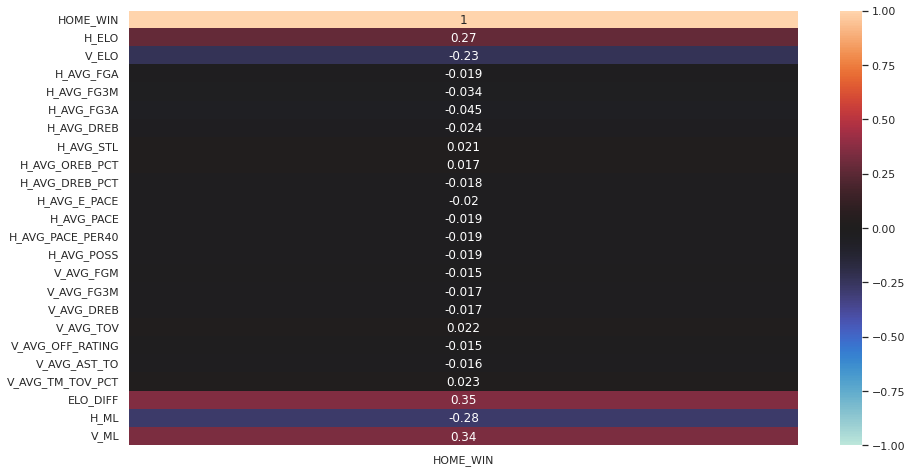

In [87]:
corr = full_df.corr()[['HOME_WIN']].drop(['TEAM_ID', 'SEASON', 'Unnamed: 0', 'H_SCORE', 'V_SCORE'])
corr = corr[abs(corr['HOME_WIN']) > 0.015]
sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, annot = True)

It's clear that the team statistics are very loosely correlated with team performance in the game and in actuality, only ELO is more strongly correlated.

Next, we can look at how the number of home games won by teams have changed over the years

In [89]:
full_df["TEAM_ABBV"] = full_df["MATCHUP"].apply(lambda x: x[:4] if 'vs' in  x else x[5:])
full_df[["TEAM_ABBV"]]

,TEAM_ABBV
0,MEM
1,TOR
2,MIN
3,DAL
4,MIL
...,...
972,WAS
973,ORL
974,CLE
975,GSW


In [90]:
full_df = full_df[['GAME_DATE', 'MATCHUP', 'HOME_WIN', 'H_ELO', 'V_ELO', 'TEAM_ID', 'ELO_DIFF', 'H_SCORE', 'V_SCORE', 'H_ML', 'V_ML', 'SEASON', "TEAM_ABBV"]]
full_df.head()

,GAME_DATE,MATCHUP,HOME_WIN,H_ELO,V_ELO,TEAM_ID,ELO_DIFF,H_SCORE,V_SCORE,H_ML,V_ML,SEASON,TEAM_ABBV
0,2015-04-15,MEM vs. IND,1,1987.175063,1608.743691,1610612763,378.431372,95,83,110,-130,2014,MEM
1,2015-04-15,CHA @ TOR,1,1660.098802,884.438398,1610612766,775.660404,92,87,-615,465,2014,TOR
2,2015-04-15,OKC @ MIN,0,686.010853,2246.400421,1610612760,-1560.389568,113,138,940,-1340,2014,MIN
3,2015-04-15,DAL vs. POR,1,1806.848621,2108.657416,1610612742,-301.808795,114,98,-245,205,2014,DAL
4,2015-04-15,MIL vs. BOS,0,1182.272614,1430.196739,1610612749,-247.924125,100,105,-230,195,2014,MIL


In [91]:
full_df["V_TEAM"] = full_df["MATCHUP"].apply(lambda x:  x[7:] if 'vs' in  x else x[:4])
full_df["WINNING_TEAM"] = full_df.apply(lambda x: x["TEAM_ABBV"] if x["HOME_WIN"] else x["V_TEAM"], axis = 1)
full_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,GAME_DATE,MATCHUP,HOME_WIN,H_ELO,V_ELO,TEAM_ID,ELO_DIFF,H_SCORE,V_SCORE,H_ML,V_ML,SEASON,TEAM_ABBV,V_TEAM,WINNING_TEAM
0,2015-04-15,MEM vs. IND,1,1987.175063,1608.743691,1610612763,378.431372,95,83,110,-130,2014,MEM,IND,MEM
1,2015-04-15,CHA @ TOR,1,1660.098802,884.438398,1610612766,775.660404,92,87,-615,465,2014,TOR,CHA,TOR
2,2015-04-15,OKC @ MIN,0,686.010853,2246.400421,1610612760,-1560.389568,113,138,940,-1340,2014,MIN,OKC,OKC
3,2015-04-15,DAL vs. POR,1,1806.848621,2108.657416,1610612742,-301.808795,114,98,-245,205,2014,DAL,POR,DAL
4,2015-04-15,MIL vs. BOS,0,1182.272614,1430.196739,1610612749,-247.924125,100,105,-230,195,2014,MIL,BOS,BOS


In [94]:
temp = full_df.groupby(by = ['SEASON', 'TEAM_ID'])['HOME_WIN'].count().to_frame()
query = """
SELECT A.SEASON, A.TEAM_ID, A.HOME_WIN, B.TEAM_ABBV
FROM temp AS A LEFT JOIN full_df AS B
ON A.TEAM_ID IS B.TEAM_ID
GROUP BY A.SEASON, A.TEAM_ID

"""
home_win_df = ps.sqldf(query, locals())
home_win_df

,SEASON,TEAM_ID,HOME_WIN,TEAM_ABBV
0,2014,1610612737,45,ATL
1,2014,1610612738,46,BOS
2,2014,1610612739,43,CLE
3,2014,1610612740,34,NOP
4,2014,1610612741,42,CHI
...,...,...,...,...
235,2021,1610612762,35,UTA
236,2021,1610612763,35,MEM
237,2021,1610612764,34,WAS
238,2021,1610612765,34,DET


In [95]:
query2 = """
SELECT SEASON, TEAM_ID, MAX(HOME_WIN) AS MAX_HOME_WINS, TEAM_ABBV
FROM home_win_df
GROUP BY SEASON

"""
max_home_win_df = ps.sqldf(query2, locals())
max_home_win_df

,SEASON,TEAM_ID,MAX_HOME_WINS,TEAM_ABBV
0,2014,1610612761,49,TOR
1,2015,1610612742,51,DAL
2,2016,1610612740,47,NOP
3,2017,1610612752,52,NYK
4,2018,1610612765,50,DET
5,2019,1610612756,39,PHX
6,2020,1610612745,44,HOU
7,2021,1610612749,40,MIL


Text(0, 0.5, 'Total Games Won')

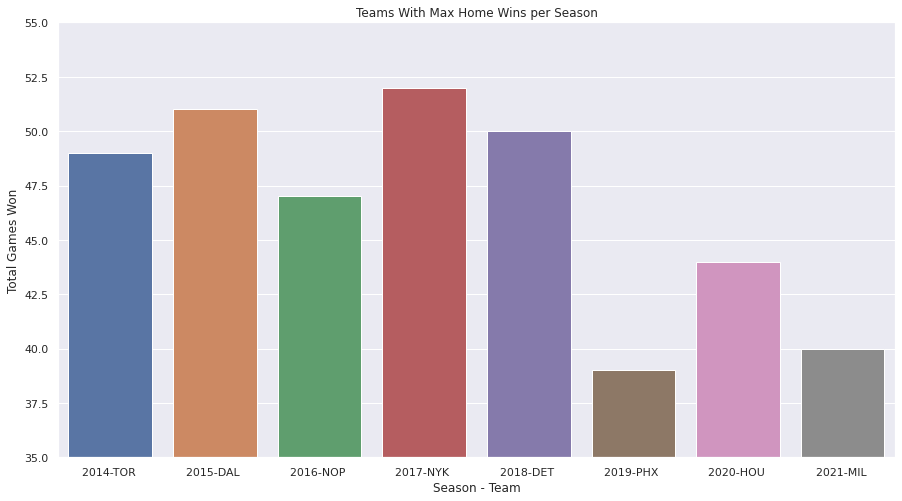

In [96]:
import seaborn as sns
import numpy as np
sns.set(rc = {'figure.figsize':(15,8)})
teams = max_home_win_df["TEAM_ABBV"].to_list()
seasons = max_home_win_df["SEASON"].to_list()
x = []
for i in range(len(teams)):
  team = teams[i]
  season =  seasons[i]
  x.append(f"{season}-{team}")

y = max_home_win_df["MAX_HOME_WINS"].to_list()
plot = sns.barplot(x = x, y = y)
plot.set(ylim = (35, 55))
plot.set(title = "Teams With Max Home Wins per Season")
plot.set_xlabel("Season - Team")
plot.set_ylabel("Total Games Won")

There seems to be a bit of a drop-off in recent years in terms of the number of home wins by the top "home" teams during the regular season (even disregarding 2019)

How is ELO distributed over the years? We can try to see which teams were the most dominant and also get some context for just how good these teams were relative to other years

In [97]:
query3 ="""
SELECT SEASON, TEAM_ID, TEAM_ABBV, MAX(ELO) AS MAX_ELO
FROM (
  SELECT SEASON, TEAM_ID, TEAM_ABBV, H_ELO AS ELO
  FROM full_df
)
GROUP BY SEASON

"""

max_elo_df = ps.sqldf(query3, locals())
max_elo_df

,SEASON,TEAM_ID,TEAM_ABBV,MAX_ELO
0,2014,1610612744,GSW,2544.014608
1,2015,1610612744,GSW,2864.326351
2,2016,1610612762,GSW,2984.234416
3,2017,1610612744,GSW,2794.697483
4,2018,1610612744,GSW,2654.816793
5,2019,1610612749,TOR,2444.465663
6,2020,1610612757,UTA,2459.771219
7,2021,1610612742,UTA,2191.418199


Text(0, 0.5, 'ELO')

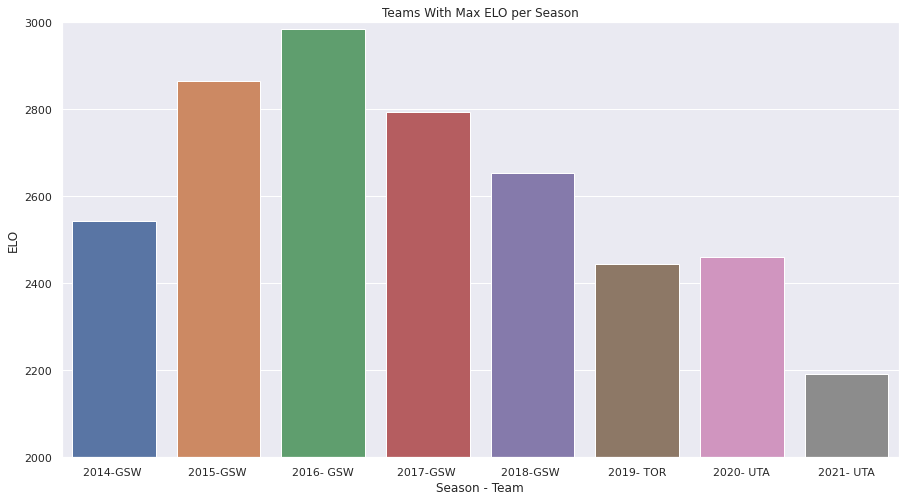

In [98]:
sns.set(rc = {'figure.figsize':(15,8)})
teams = max_elo_df["TEAM_ABBV"].to_list()
seasons = max_elo_df["SEASON"].to_list()
x = []
for i in range(len(teams)):
  team = teams[i]
  season =  seasons[i]
  x.append(f"{season}-{team}")

y = max_elo_df["MAX_ELO"].to_list()
plot = sns.barplot(x = x, y = y)
plot.set(ylim = (2000, 3000))
plot.set(title = "Teams With Max ELO per Season")
plot.set_xlabel("Season - Team")
plot.set_ylabel("ELO")

Unsurprisingly, the Warriors absolutely dominated the 2014-2018 seasons with ELOs nearly double the league average. This was the stretch during which they also won 3 championships. It's interesting to note just how dominant they were. At their peak, the 2016 Warriors were nearly 500 ELO points higher than the 2019-2020 Toronto Raptors, coming off a championship season. They were truly in a league of their own.

Lastly, let's have visualize the relationship between a team's ELO and their wins for the regular season.

In [104]:
query4 ="""
SELECT A.SEASON, A.TEAM_ID, A.TEAM_ABBV, A.MAX_ELO, B.HOME_WIN
FROM max_elo_df AS A JOIN home_win_df AS B
ON A.TEAM_ID IS B.TEAM_ID AND A.SEASON IS B.SEASON 

"""

wins_of_max_elo_df = ps.sqldf(query4, locals())
wins_of_max_elo_df

,SEASON,TEAM_ID,TEAM_ABBV,MAX_ELO,HOME_WIN
0,2014,1610612744,GSW,2544.014608,41
1,2015,1610612744,GSW,2864.326351,42
2,2016,1610612762,GSW,2984.234416,42
3,2017,1610612744,GSW,2794.697483,41
4,2018,1610612744,GSW,2654.816793,34
5,2019,1610612749,TOR,2444.465663,33
6,2020,1610612757,UTA,2459.771219,41
7,2021,1610612742,UTA,2191.418199,27


In [105]:
query5 ="""
SELECT A.SEASON, A.TEAM_ID, A.TEAM_ABBV, A.MAX_HOME_WINS, B.H_ELO AS ELO
FROM max_home_win_df AS A LEFT JOIN full_df AS B
ON A.TEAM_ID IS B.TEAM_ID AND A.SEASON IS B.SEASON 
GROUP BY A.SEASON, A.TEAM_ID
"""

elos_of_max_wins_df = ps.sqldf(query5, locals())
elos_of_max_wins_df

,SEASON,TEAM_ID,TEAM_ABBV,MAX_HOME_WINS,ELO
0,2014,1610612761,TOR,49,2387.326906
1,2015,1610612742,DAL,51,2696.049843
2,2016,1610612740,NOP,47,2970.372248
3,2017,1610612752,NYK,52,2277.911126
4,2018,1610612765,DET,50,2567.749697
5,2019,1610612756,PHX,39,2392.717188
6,2020,1610612745,HOU,44,2451.613435
7,2021,1610612749,MIL,40,1919.054070


In [106]:
query6 ="""
SELECT A.SEASON, A.TEAM_ID, A.TEAM_ABBV, A.HOME_WIN, B.H_ELO AS ELO
FROM home_win_df AS A JOIN full_df AS B
ON A.TEAM_ID IS B.TEAM_ID AND A.SEASON IS B.SEASON 
GROUP BY A.SEASON, A.TEAM_ID
"""

elos_and_wins_df = ps.sqldf(query6, locals())
elos_and_wins_df

,SEASON,TEAM_ID,TEAM_ABBV,HOME_WIN,ELO
0,2014,1610612737,ATL,45,2458.188678
1,2014,1610612738,BOS,46,2350.607483
2,2014,1610612739,CLE,43,2328.578926
3,2014,1610612740,NOP,34,2431.266813
4,2014,1610612741,CHI,42,2183.896958
...,...,...,...,...,...
235,2021,1610612762,UTA,35,2134.773564
236,2021,1610612763,MEM,35,2152.288164
237,2021,1610612764,WAS,34,2080.411166
238,2021,1610612765,DET,34,2110.402721


Text(0, 0.5, 'ELO')

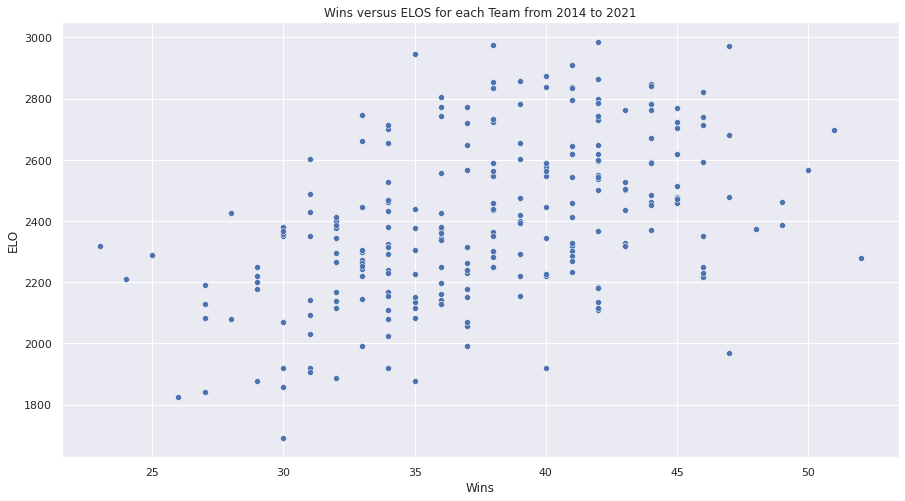

In [107]:
sns.set(rc = {'figure.figsize':(15,8)})
x = elos_and_wins_df["HOME_WIN"].to_list()
y = elos_and_wins_df["ELO"].to_list()
plot = sns.scatterplot(x = x, y = y)
plot.set(title = "Wins versus ELOS for each Team from 2014 to 2021")
plot.set_xlabel("Wins")
plot.set_ylabel("ELO")

While there is some variation, we can clearly see that teams with higher ELO tended to have more wins during the season.

## Modeling



Now, we are going to train a few machine learning models that will classify each set of features by whether or not the home team won that game.

### Feature Importance and Decomposition

We can take a look at which features will be most significant for our Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn import svm

model = GradientBoostingClassifier(n_estimators = 30, min_samples_leaf= 15, learning_rate = 0.1)
selector = RFE(model, n_features_to_select=10, step=1)
selector = selector.fit(X_train, y_train)

In [ ]:
mask = selector.support_
sig_features = []
for i in range(len(mask)):
    if mask[i]:
        sig_features.append(X_train.columns[i])
print(sig_features)

['H_AVG_FG3A', 'H_AVG_FTM', 'H_AVG_OREB_PCT', 'H_AVG_DREB_PCT', 'H_AVG_E_PACE', 'V_AVG_FTA', 'V_AVG_REB', 'H_ELO', 'V_ELO', 'ELO_DIFF']


We can also plot the first two PCA components of our data to get an idea of how separable the data is.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(X_train)
X_train_pca = pca.transform(X_train)
print(pca.explained_variance_ratio_)

[0.75793585 0.24118253]


The first two components alone account for over 99% of the total variance in the dataset!

Text(0.5, 1.0, 'Principal Components vs Home Win')

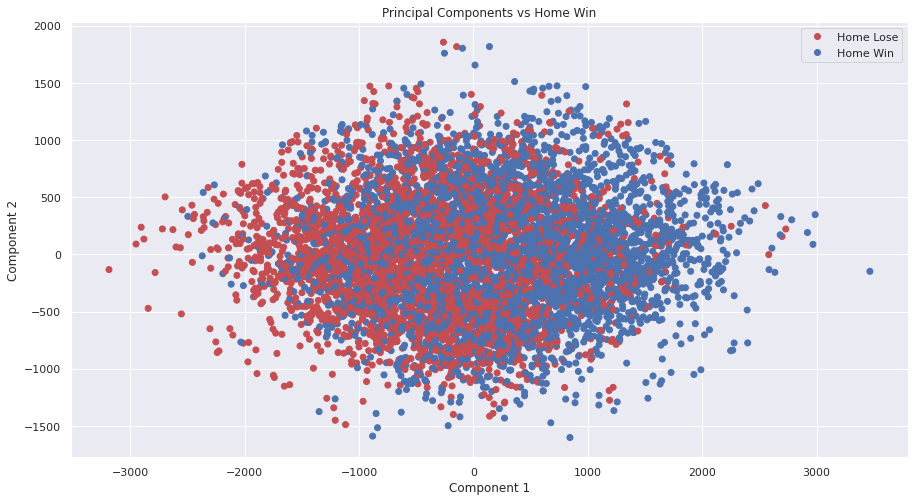

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

colors = ListedColormap(['r','b'])
classes = ['Home Lose', 'Home Win']
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c = y_train, cmap = colors)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Principal Components vs Home Win")

We can clearly see that there is clear trend along the first principal component on the x-axis that the home team is more likely to lose when it is negative and vice versa when positive. Also note though, that there are still sizeable amount of blue on the left side and red on the right side, indicating that this dataset is not easily separable into clear binary classes and perhaps our features do not capture enough of the difference between the home win and loss groups

### Training Models

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

models = {}

In [ ]:
model_list = []

We'll start with a basic logistic regression classifier. We chose this as a baseline for our other models beceause it is the simplest model in terms of complexity as well as time to train. 

In [ ]:
model_log = LogisticRegression(random_state = 42, max_iter = 10000)
model_log.fit(X_train,y_train)

predictions_log = model_log.predict(X_test)
print(f'Test accuracy: {accuracy_score(y_test, predictions_log)}')
print(f'Train accuracy: {accuracy_score(y_train, model_log.predict(X_train))}')

models[accuracy_score(y_test, predictions_log)] = model_log

Test accuracy: 0.6069600818833163
Train accuracy: 0.6600717200445159


Next, we'll try a gradient boosting classifier. This is one of the most powerful and widely used classifiers for any binary classification task. It is typically able to do well with complex data that is being underfit by a single decision tree or a logistic regression model. We are running a gridsearchcv to determine which hyperparameters are most optimal.

In [ ]:
parameters = {'n_estimators': [30, 60, 120, 180], 'learning_rate': [0.1, 0.15], 'min_samples_leaf': [5, 10, 15]}
model = GradientBoostingClassifier()
clf_boost = GridSearchCV(model, parameters, n_jobs = 1).fit(X_train, y_train)

In [ ]:
print(clf_boost.best_params_)

{'learning_rate': 0.1, 'min_samples_leaf': 15, 'n_estimators': 30}


In [ ]:
clf_boost = GradientBoostingClassifier(n_estimators = 30, min_samples_leaf= 15, learning_rate = 0.1).fit(X_train, y_train)
predictions_boost = clf_boost.predict(X_test)
print(f'Test accuracy: {accuracy_score(y_test, predictions_boost)}')
print(f'Train accuracy: {accuracy_score(y_train, clf_boost.predict(X_train))}')

models[accuracy_score(y_test, predictions_boost)] = clf_boost

Test accuracy: 0.6049129989764586
Train accuracy: 0.6798565599109683


We can try to improve the accuracy of our prediction probability by calibrating the model so for every prediction that gives the home team an x% chance of winning, the home team wins in those scenarios about x% of the time. This can be done using the calibratedclassifercv model in sklearn. We feed in our previous gradient boosting model and we get a new model that ideally provides better likelihood predictions. This makes finding edge using a betting model more reliable over an algorithm that can only discriminate between two classes without providing reliable likelihoods.

In [ ]:
model_cal = CalibratedClassifierCV(clf_boost, cv = 'prefit')
model_cal.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=GradientBoostingClassifier(min_samples_leaf=15,
                                                                 n_estimators=30),
                       cv='prefit')

In [ ]:
predictions_boost_cal = model_cal.predict(X_test)
print(f'Test Accuracy: {accuracy_score(y_test, predictions_boost_cal)}')
print(f'Train Accuracy: {accuracy_score(y_train, model_cal.predict(X_train))}')

models[accuracy_score(y_test, predictions_boost_cal)] = model_cal

Test Accuracy: 0.6100307062436029
Train Accuracy: 0.6789909731668109


We can also use a Random Forest Classifier as an alternative tree-based model. Here, rather than boosting, we are trying bagging in the potential scenario where overfitting is causing less accurate results and averaging over a large number of estimators will improve results.

In [ ]:
model_rf = RandomForestClassifier(n_estimators = 200, random_state = 42).fit(X_train, y_train)
predictions_rf = model_rf.predict(X_test)
print(f'Test accuracy: {accuracy_score(y_test, predictions_rf)}')
print(f'Train accuracy: {accuracy_score(y_train, model_rf.predict(X_train))}')
models[accuracy_score(y_test, predictions_rf)] = model_rf

Test accuracy: 0.609007164790174
Train accuracy: 1.0


We can also build a basic neural network classifier. This is the last classifier we will test. Because the data has so many features and the classes are not easily separable, a neural network has the ability to create very nuanced decision boundaries that may more accurately separate the data into its proper classes. We train a relatively large neural network due to the complexity and number of features we have.

In [ ]:
clf_neural = MLPClassifier(random_state=42, hidden_layer_sizes = (1000, 800, 600, 400, 400, 200, 200), max_iter=500).fit(X_train, y_train)

In [ ]:
predictions_neural = clf_neural.predict(X_test)
print(f'Test accuracy: {accuracy_score(y_test, predictions_neural)}')
print(f'Train accuracy: {accuracy_score(y_train, clf_neural.predict(X_train))}')

models[accuracy_score(y_test, predictions_neural)] = clf_neural

Test accuracy: 0.6192425793244627
Train accuracy: 0.6625448250278224


We can now save all of our models and their performance

In [ ]:
print(models)

{0.6069600818833163: LogisticRegression(max_iter=10000, random_state=42), 0.6049129989764586: GradientBoostingClassifier(min_samples_leaf=15, n_estimators=30), 0.6100307062436029: CalibratedClassifierCV(base_estimator=GradientBoostingClassifier(min_samples_leaf=15,
                                                                 n_estimators=30),
                       cv='prefit'), 0.609007164790174: RandomForestClassifier(n_estimators=200, random_state=42), 0.6192425793244627: MLPClassifier(hidden_layer_sizes=(1000, 800, 600, 400, 400, 200, 200),
              max_iter=500, random_state=42)}


In [ ]:
models = {0.6069600818833163: LogisticRegression(max_iter=10000, random_state=42), 0.6049129989764586: GradientBoostingClassifier(min_samples_leaf=15, n_estimators=30), 0.6100307062436029: CalibratedClassifierCV(base_estimator=GradientBoostingClassifier(min_samples_leaf=15,
                                                                 n_estimators=30),
                       cv='prefit'), 0.609007164790174: RandomForestClassifier(random_state=42), 0.6192425793244627: MLPClassifier(hidden_layer_sizes=(1000, 800, 600, 400, 400, 200, 200),
              max_iter=500, random_state=42)}

In [ ]:
model_list = [(accuracy_score(y_test, predictions_log), "Logistic Regression", model_log), (accuracy_score(y_test, predictions_boost), "Gradient Boosting Classifier", clf_boost), (accuracy_score(y_test, predictions_boost_cal), "Calibrated Classifier", model_cal),
              (accuracy_score(y_test, predictions_neural), "MLP Classifier", clf_neural), (accuracy_score(y_test, predictions_rf), "Random Forest Classifier", model_rf)]

[Text(0, 0, 'Logistic Regression'),
 Text(0, 0, 'Gradient Boosting Classifier'),
 Text(0, 0, 'Calibrated Classifier'),
 Text(0, 0, 'MLP Classifier'),
 Text(0, 0, 'Random Forest Classifier')]

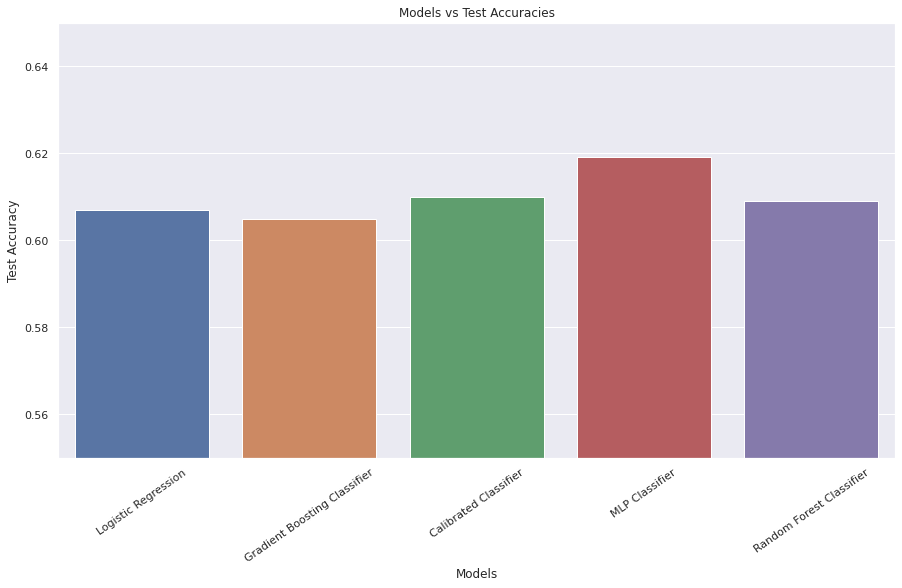

In [ ]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
x = [x[1] for x in model_list]
y = [x[0] for x in model_list]
plot = sns.barplot(x = x, y = y)
plot.set(title = "Models vs Test Accuracies", ylim = (0.55, 0.65))
plot.set_xlabel("Models")
plot.set_ylabel("Test Accuracy")
plot.set_xticklabels(plot.get_xticklabels(), rotation = 35)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
classifiers = [x[2] for x in model_list]
classifiers

[LogisticRegression(max_iter=10000, random_state=42),
 GradientBoostingClassifier(min_samples_leaf=15, n_estimators=30),
 CalibratedClassifierCV(base_estimator=GradientBoostingClassifier(min_samples_leaf=15,
                                                                  n_estimators=30),
                        cv='prefit'),
 MLPClassifier(hidden_layer_sizes=(1000, 800, 600, 400, 400, 200, 200),
               max_iter=500, random_state=42),
 RandomForestClassifier(n_estimators=200, random_state=42)]

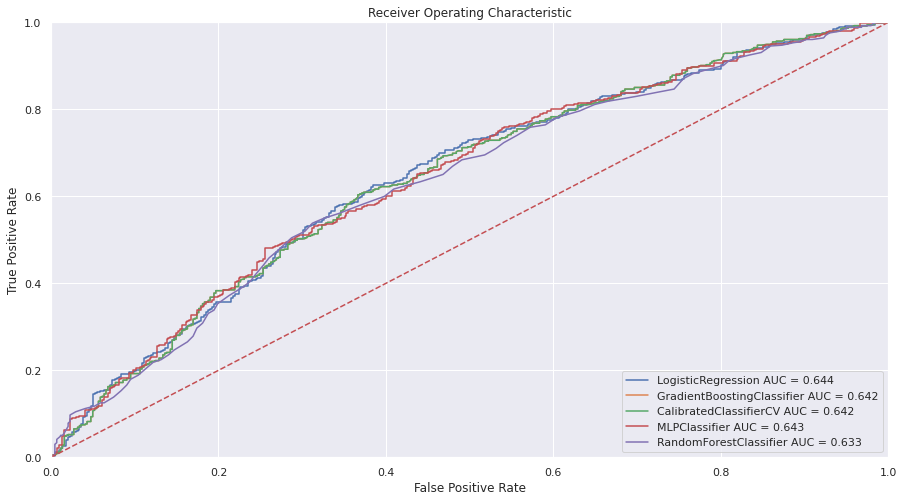

In [ ]:
import sklearn.metrics as metrics
aucs = []
for i, clf in enumerate(classifiers):
  preds = clf.predict_proba(X_test)[:,1]

  fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
  roc_auc = metrics.auc(fpr, tpr)
  model_name = type(clf).__name__
  plt.plot(fpr, tpr, label = f'{model_name} AUC = %0.3f' % roc_auc)
  aucs.append(roc_auc)

plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Backtesting

Now we have the best part of this entire process: backtesting our model.
<br>
It is not enough to simply predict the winner of a game, we want to develop a model that is able to help us make profitable decisions when betting on games. To do this, we need an understanding of how confident our model is in each of its predictions. Luckily sklearn already has a built in function, predict_proba(), which returns the class likelihood percentage for our model.
<br>
While there are various betting strategies available, one of the most famous is the Kelly Criterion. The Kelly Criterion states that in any gambling situation, the optimal bet sizing is given by the formula:
<br>
$$f^* = p - \frac{q}{b}$$
<br>where p is the probability of the "good result" happening, q is the probability of the "bad result" and b is the payout given by the proportion of the bet earned in a win.
<br>
We will be using this formula to make proper bet sizings and adjust various hyperparameters to make this strategy our own.

In [ ]:
best_model_auc = classifiers[np.argmax(aucs)]
best_model_auc

LogisticRegression(max_iter=10000, random_state=42)

In [ ]:
best_model_accuracy = classifiers[np.argmax([x[0] for x in model_list])]
best_model_accuracy

MLPClassifier(hidden_layer_sizes=(1000, 800, 600, 400, 400, 200, 200),
              max_iter=500, random_state=42)

In [ ]:
probs_auc = best_model_auc.predict_proba(X_test)

Implied odds can be thought of almost like the probability that the bookmakers give for a team to win. We will calculate these using specific formulas that convert american odd lines to these implied odds. If our model is more confident in a win for one side than the bookies, it is likely favorable to bet on that team. This is known as edge.

In [ ]:
h_prob = []
v_prob = []
for prob in probs_auc:
    h_prob.append(prob[1])
    v_prob.append(prob[0])
test_df['H_PROB'] = h_prob
test_df['V_PROB'] = v_prob
test_df['H_IMP_ODDS'] = test_df['H_ML'].apply(lambda x: 100 / (x + 100) if x > 0 else (abs(x))/(abs(x) + 100))
test_df['V_IMP_ODDS'] = test_df['V_ML'].apply(lambda x: 100 / (x + 100) if x > 0 else (abs(x))/(abs(x) + 100))

test_df = test_df.iloc[::-1]
test_df.reset_index(drop = True, inplace = True)

In [ ]:
test_df.head()

,Unnamed: 0,GAME_DATE,MATCHUP,HOME_WIN,H_ELO,V_ELO,TEAM_ID,H_AVG_FGM,H_AVG_FGA,H_AVG_FG_PCT,...,ELO_DIFF,H_SCORE,V_SCORE,H_ML,V_ML,SEASON,H_PROB,V_PROB,H_IMP_ODDS,V_IMP_ODDS
0,976,2021-10-21,MIL @ MIA,1,1651.020380,1844.182860,1610612749,41.0,93.0,0.441,...,-193.162480,137,95,-150,130,2021,0.446659,0.553341,0.600000,0.434783
1,975,2021-10-21,LAC @ GSW,1,1620.043842,1843.142234,1610612746,47.0,93.0,0.505,...,-223.098391,115,113,-180,160,2021,0.536060,0.463940,0.642857,0.384615
2,974,2021-10-22,CHA @ CLE,0,1151.597226,1376.571893,1610612766,35.0,86.0,0.407,...,-224.974668,112,123,115,-135,2021,0.423083,0.576917,0.465116,0.574468
3,973,2021-10-22,ORL vs. NYK,0,1150.837404,1361.398818,1610612753,36.0,81.0,0.444,...,-210.561414,96,121,290,-350,2021,0.503862,0.496138,0.256410,0.777778
4,972,2021-10-22,IND @ WAS,1,1327.800689,1539.714469,1610612754,48.0,117.0,0.410,...,-211.913780,135,134,110,-130,2021,0.440162,0.559838,0.476190,0.565217


We can visualize our bankroll over the entire season and tune various parameters depending on how we want to bet based on our model results.
We will mainly focus on a few: upper and lower bound (the maximum and minimum edge for our model to have over the implied odds in order for us to place a bet), the fraction of the kelly criterion bet sizing we will actually use, the threshold for a bet sizing (given in terms of proportion of our bankroll) that will be flagged as a large bet, and the "big bet handicap" (the fractional multiplier by which we will apply to any big bet to reduce its sizing further).

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact
from datetime import datetime
import matplotlib.dates as mdates


lower_bnd = 0
upper_bnd = 0
kelly = 0
max_percent = 0
big_bet_handicap = 0
@interact(lower_bnd=(0, 0.25), upper_bnd=(lower_bnd, 1.0), kelly=(0, 1.0), max_percent=(0, 0.25), big_bet_handicap=(0, 1.0))
def backtest(lower_bnd = 0.15, upper_bnd = 0.35, kelly = 0.2, max_percent = 0.04, big_bet_handicap = 0.1):
    bankroll = [1000]
    prev_date = '2021-10-22'
    dates = ['2021-10-22']
    day_profit = 0

    #TUNABLE PARAMETERS
    lower_bnd = lower_bnd # Minimum edge needed to place bet
    upper_bnd = upper_bnd # Maximum edge
    kelly = kelly # Bet sizing (fractional kelly criterion)
    max_odds = 600 # Maximum odds willing to bet on (under-dog)
    min_odds = -500 # Minimum odds willing to bet on (over-dog)
    max_percent = max_percent # Any bet larger than this fraction of bankroll will be flagged as a "big bet"
    big_bet_handicap = big_bet_handicap # All "big bets" will be multiplied by this factor

    bet_cnt = 0
    fav_bets = 0
    under_bets = 0
    big_bet = 0
    success_bets = 0
    big_bet_flag = False

    bad_bets = []
    for index, row in test_df.iterrows():
        big_bet_flag = False
        if bankroll[-1] == 0:
            break
        if row['GAME_DATE'] != prev_date:
            bankroll.append(bankroll[-1] + day_profit)
            day_profit = 0
            prev_date = row['GAME_DATE']
            dates.append(datetime.strptime(prev_date, '%Y-%M-%d'))
        bet_amt = 0
        h_odds_multi = 1
        v_odds_multi = 1
        if int(row['H_ML']) > 0:
            h_bet = row['H_PROB'] - (row['V_PROB']/(int(row['H_ML'])/100))
            h_odds_multi = int(row['H_ML'])/100
        else:
            h_bet = row['H_PROB'] - (row['V_PROB']/(100/abs(int(row['H_ML']))))
            h_odds_multi = 100/abs(int(row['H_ML']))

        if int(row['V_ML']) > 0:
            v_bet = row['V_PROB'] - (row['H_PROB']/(int(row['V_ML'])/100))
            v_odds_multi = (int(row['V_ML'])/100)
        else:
            v_bet = row['V_PROB'] - (row['H_PROB']/(100/abs(int(row['V_ML']))))
            v_odds_multi = (100/abs(int(row['V_ML'])))

        if h_bet > lower_bnd and h_bet < upper_bnd and int(row['H_ML']) < max_odds:
            bet_amt = bankroll[-1]*h_bet*kelly
            if bet_amt > bankroll[-1]*max_percent:
                bet_amt = bankroll[-1]*max_percent*big_bet_handicap
                big_bet += 1
                big_bet_flag = True
            bet_cnt += 1
            if row['H_ML'] < 0:
                fav_bets += 1
            else:
                under_bets += 1
            if row['H_SCORE'] > row['V_SCORE']:
                success_bets += 1
                day_profit += (h_odds_multi)*bet_amt
            else:
                if big_bet_flag:
                    bad_bets.append((row['GAME_DATE'], row['MATCHUP'], row['H_SCORE'] - row['V_SCORE'], 'H'))
                day_profit -= bet_amt
        if v_bet > lower_bnd and v_bet < upper_bnd and int(row['V_ML']) < max_odds:
            bet_amt = bankroll[-1]*v_bet*kelly
            if bet_amt > bankroll[-1]*max_percent:
                bet_amt = bankroll[-1]*max_percent*big_bet_handicap
                big_bet += 1
                big_bet_flag = True
            bet_cnt += 1
            if row['V_ML'] < 0:
                fav_bets += 1
            else:
                under_bets += 1
            if row['V_SCORE'] > row['H_SCORE']:
                success_bets += 1
                day_profit += v_odds_multi*bet_amt
            else:
                if big_bet_flag:
                    bad_bets.append((row['GAME_DATE'], row['MATCHUP'], row['H_SCORE'] - row['V_SCORE'], 'V'))
                day_profit -= bet_amt
    plt.xlabel('Day')
    plt.ylabel('Bankroll')
    plt.title('Bankroll over the 2021 Season Using Best AUC Model')
    return plt.plot(bankroll), f'Min: ${min(bankroll)} and Max: ${max(bankroll)}', f'Average number of bets per day: {bet_cnt / len(bankroll)}'

interactive(children=(FloatSlider(value=0.15, description='lower_bnd', max=0.25), FloatSlider(value=0.35, desc…

In [ ]:
pred_home_upsets_auc = len(test_df[(test_df['H_PROB'] > 0.5) & (test_df['H_ML'] > 0) & (test_df['HOME_WIN'] == 1)])
pred_away_upsets_auc = len(test_df[(test_df['V_PROB'] > 0.5) & (test_df['V_ML'] > 0) & (test_df['HOME_WIN'] == 0)])
total_upsets = len(test_df[(test_df['H_ML'] > 0) & (test_df['HOME_WIN'] == 1)]) + len(test_df[(test_df['V_ML'] > 0) & (test_df['HOME_WIN'] == 0)])
upset_pred_recall_auc = (pred_home_upsets_auc + pred_away_upsets_auc)/total_upsets
print(f'Upset Recall Accuracy: {upset_pred_recall_auc}')

pred_underdog_auc = len(test_df[(test_df['H_PROB'] > 0.5) & (test_df['H_ML'] > 0)]) + len(test_df[(test_df['V_PROB'] > 0.5) & (test_df['V_ML'] > 0)])
upset_pred_prec_auc = (pred_home_upsets_auc + pred_away_upsets_auc) / pred_underdog_auc
print(f'Upset Precision Accuracy: {upset_pred_prec_auc}')

Upset Recall Accuracy: 0.25165562913907286
Upset Precision Accuracy: 0.35514018691588783


We can also try using our model that had the highest prediction accuracy rather than the highest AUC score and see how profitable that model is instead.

In [ ]:
probs = best_model_accuracy.predict_proba(X_test)

In [ ]:
h_prob = []
v_prob = []
for prob in probs:
    h_prob.append(prob[1])
    v_prob.append(prob[0])
test_df['H_PROB'] = h_prob
test_df['V_PROB'] = v_prob
test_df['H_IMP_ODDS'] = test_df['H_ML'].apply(lambda x: 100 / (x + 100) if x > 0 else (abs(x))/(abs(x) + 100))
test_df['V_IMP_ODDS'] = test_df['V_ML'].apply(lambda x: 100 / (x + 100) if x > 0 else (abs(x))/(abs(x) + 100))

test_df = test_df.iloc[::-1]
test_df.reset_index(drop = True, inplace = True)
test_df.head()

,Unnamed: 0,GAME_DATE,MATCHUP,HOME_WIN,H_ELO,V_ELO,TEAM_ID,H_AVG_FGM,H_AVG_FGA,H_AVG_FG_PCT,...,ELO_DIFF,H_SCORE,V_SCORE,H_ML,V_ML,SEASON,H_PROB,V_PROB,H_IMP_ODDS,V_IMP_ODDS
0,0,2022-03-09,LAC vs. WAS,1,1874.704155,1205.710080,1610612746,42.4,85.8,0.4946,...,668.994075,115,109,-160,140,2021,0.512383,0.487617,0.615385,0.416667
1,1,2022-03-09,SAC vs. DEN,0,1030.490386,1881.983992,1610612758,38.6,89.4,0.4316,...,-851.493606,100,106,220,-260,2021,0.522075,0.477925,0.312500,0.722222
2,2,2022-03-09,POR @ UTA,1,2178.527110,1407.582016,1610612757,41.6,87.0,0.4784,...,770.945094,123,85,-4000,1400,2021,0.456266,0.543734,0.975610,0.066667
3,3,2022-03-09,NYK @ DAL,0,1795.505908,1296.548706,1610612752,40.2,89.2,0.4496,...,498.957202,77,107,-400,330,2021,0.490850,0.509150,0.800000,0.232558
4,4,2022-03-09,TOR @ SAS,0,1452.429009,1691.268868,1610612761,40.8,83.4,0.4896,...,-238.839859,104,119,100,-120,2021,0.514989,0.485011,0.500000,0.545455


In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact
from datetime import datetime
import matplotlib.dates as mdates


lower_bnd = 0
upper_bnd = 0
kelly = 0
max_percent = 0
big_bet_handicap = 0
@interact(lower_bnd=(0, 0.25), upper_bnd=(lower_bnd, 1.0), kelly=(0, 1.0), max_percent=(0, 0.25), big_bet_handicap=(0, 1.0))
def backtest(lower_bnd = 0.15, upper_bnd = 0.35, kelly = 0.2, max_percent = 0.04, big_bet_handicap = 0.1):
    bankroll = [1000]
    prev_date = '2021-10-22'
    dates = ['2021-10-22']
    day_profit = 0

    #TUNABLE PARAMETERS
    lower_bnd = lower_bnd # Minimum edge needed to place bet
    upper_bnd = upper_bnd # Maximum edge
    kelly = kelly # Bet sizing (fractional kelly criterion)
    max_odds = 600 # Maximum odds willing to bet on (under-dog)
    min_odds = -500 # Minimum odds willing to bet on (over-dog)
    max_percent = max_percent # Any bet larger than this fraction of bankroll will be flagged as a "big bet"
    big_bet_handicap = big_bet_handicap # All "big bets" will be multiplied by this factor

    bet_cnt = 0
    fav_bets = 0
    under_bets = 0
    big_bet = 0
    success_bets = 0
    big_bet_flag = False

    bad_bets = []
    for index, row in test_df.iterrows():
        big_bet_flag = False
        if bankroll[-1] == 0:
            break
        if row['GAME_DATE'] != prev_date:
            bankroll.append(bankroll[-1] + day_profit)
            day_profit = 0
            prev_date = row['GAME_DATE']
            dates.append(datetime.strptime(prev_date, '%Y-%M-%d'))
        bet_amt = 0
        h_odds_multi = 1
        v_odds_multi = 1
        if int(row['H_ML']) > 0:
            h_bet = row['H_PROB'] - (row['V_PROB']/(int(row['H_ML'])/100))
            h_odds_multi = int(row['H_ML'])/100
        else:
            h_bet = row['H_PROB'] - (row['V_PROB']/(100/abs(int(row['H_ML']))))
            h_odds_multi = 100/abs(int(row['H_ML']))

        if int(row['V_ML']) > 0:
            v_bet = row['V_PROB'] - (row['H_PROB']/(int(row['V_ML'])/100))
            v_odds_multi = (int(row['V_ML'])/100)
        else:
            v_bet = row['V_PROB'] - (row['H_PROB']/(100/abs(int(row['V_ML']))))
            v_odds_multi = (100/abs(int(row['V_ML'])))

        if h_bet > lower_bnd and h_bet < upper_bnd and int(row['H_ML']) < max_odds:
            bet_amt = bankroll[-1]*h_bet*kelly
            if bet_amt > bankroll[-1]*max_percent:
                bet_amt = bankroll[-1]*max_percent*big_bet_handicap
                big_bet += 1
                big_bet_flag = True
            bet_cnt += 1
            if row['H_ML'] < 0:
                fav_bets += 1
            else:
                under_bets += 1
            if row['H_SCORE'] > row['V_SCORE']:
                success_bets += 1
                day_profit += (h_odds_multi)*bet_amt
            else:
                if big_bet_flag:
                    bad_bets.append((row['GAME_DATE'], row['MATCHUP'], row['H_SCORE'] - row['V_SCORE'], 'H'))
                day_profit -= bet_amt
        if v_bet > lower_bnd and v_bet < upper_bnd and int(row['V_ML']) < max_odds:
            bet_amt = bankroll[-1]*v_bet*kelly
            if bet_amt > bankroll[-1]*max_percent:
                bet_amt = bankroll[-1]*max_percent*big_bet_handicap
                big_bet += 1
                big_bet_flag = True
            bet_cnt += 1
            if row['V_ML'] < 0:
                fav_bets += 1
            else:
                under_bets += 1
            if row['V_SCORE'] > row['H_SCORE']:
                success_bets += 1
                day_profit += v_odds_multi*bet_amt
            else:
                if big_bet_flag:
                    bad_bets.append((row['GAME_DATE'], row['MATCHUP'], row['H_SCORE'] - row['V_SCORE'], 'V'))
                day_profit -= bet_amt
    plt.xlabel('Day')
    plt.ylabel('Bankroll')
    plt.title('Bankroll over the 2021 Season Using Best Accuracy Model')
    return plt.plot(bankroll), f'Min: ${min(bankroll)} and Max: ${max(bankroll)}', f'Average number of bets per day: {bet_cnt / len(bankroll)}'

interactive(children=(FloatSlider(value=0.15, description='lower_bnd', max=0.25), FloatSlider(value=0.35, desc…

In [ ]:
pred_home_upsets_acc = len(test_df[(test_df['H_PROB'] > 0.5) & (test_df['H_ML'] > 0) & (test_df['HOME_WIN'] == 1)])
pred_away_upsets_acc = len(test_df[(test_df['V_PROB'] > 0.5) & (test_df['V_ML'] > 0) & (test_df['HOME_WIN'] == 0)])
total_upsets = len(test_df[(test_df['H_ML'] > 0) & (test_df['HOME_WIN'] == 1)]) + len(test_df[(test_df['V_ML'] > 0) & (test_df['HOME_WIN'] == 0)])
upset_pred_recall_acc = (pred_home_upsets_acc + pred_away_upsets_acc)/total_upsets
print(f'Upset Recall Accuracy: {upset_pred_recall_acc}')
pred_underdog_acc = len(test_df[(test_df['H_PROB'] > 0.5) & (test_df['H_ML'] > 0)]) + len(test_df[(test_df['V_PROB'] > 0.5) & (test_df['V_ML'] > 0)])
upset_pred_prec_acc = (pred_home_upsets_acc + pred_away_upsets_acc) / pred_underdog_acc

print(f'Upset Precision Accuracy: {upset_pred_prec_acc}')

Upset Recall Accuracy: 0.4304635761589404
Upset Precision Accuracy: 0.3333333333333333


An interesting performance metric to analyze is how well our models are able to predict upsets. This is often where there is a lot of money to be made, as underdog odds which pay out significantly better than betting on the favorite every time. We analyzed how the precision and recall of our models were specifically related to predicting upsets (the model predicting the probability of the underdog winning to be greater than 50%). The underdog is defined to be the team where the odds are greater than 0, indicating that the bookmakers believe that team is less likely to win.

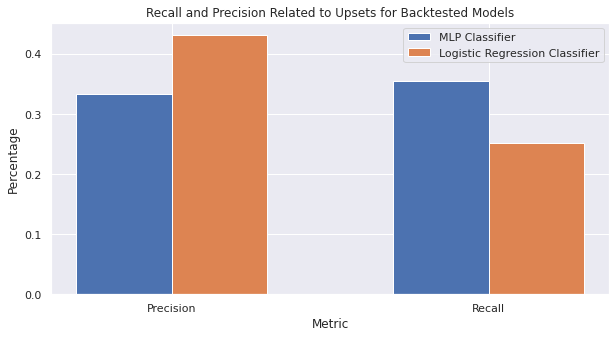

In [ ]:
N = 2

blue_bar = (upset_pred_prec_acc, upset_pred_prec_auc)
orange_bar = (upset_pred_recall_acc, upset_pred_recall_auc)

ind = np.arange(N)

plt.figure(figsize=(10,5))

width = 0.3       

plt.bar(ind, blue_bar , width, label='MLP Classifier')
plt.bar(ind + width, orange_bar, width, label='Logistic Regression Classifier')

plt.xlabel('Metric')
plt.ylabel('Percentage')
plt.title('Recall and Precision Related to Upsets for Backtested Models')

plt.xticks(ind + width / 2, ('Precision', 'Recall'))

plt.legend(loc='best')
plt.show()

We can see that while the MLP classifier was able to identify and capture more of the upsets, clearly there was a tradeoff in the precision, where a lower percentage of the upsets it predicted actually came true. This is likely while the model did not perform as well in terms of returning profit. While underdog bets have very good payout, betting on them too often in large amounts will eventually lead to the bankroll drying up before a big win is possible.
<br>
The logistic regression classifer captures a much lower percentage of the upsets that occur but of the ones it does predict, it is much more precise. We likely want a model that has a balance between these two in terms of precision and recall in order to maximize profit.

## Conclusion

So, what can we conclude from this analysis and our models?
<br>
Firstly, predicting the winner of NBA games with high accuracy requires a lot more than just general team stats and averages. If we wanted to improve our accuracy, we'd probably have to grab more player-specific data that would allow us to adjust for injuries, as well as general player improvement and playstyle. We could also look into other factors such as where teams like to take their shots, what kind of strategies they like to run, even look at the strength of their recent schedule. With our current features, the data is just not easy to separate even with the best models which showed high bias.
<br>
Secondly, while it is possible to create a profitable model, it's not as simple as a plug and play classifier. There are many different parameters that must be tuned to create a decent betting strategy and these parameters are incredibly sensitive. One model used with a specific betting strategy may not work from year to year and will almost certainly perform wildly different if the betting strategy is just slightly adjusted. Also, prediction accuracy is not the only factor that determines profitability. Less accurate models can make more well-informed decisions if they are able to identify profiable bets
<br>
Lastly, a model needs to have a proper balance of predicting upsets and choosing obvious favorites. A model that chooses all favorites will never be profitable given the relatively high rate of upsets in the sport, but a model that always picks underdogs will bleed out in between the occasional wins. Thus, finding the proper ratio of recall and precision for identifying valuable underdog bets is extremely important.